# **1. Regression discontinuity: banking recovery**
After a debt has been legally declared "uncollectable" by a bank, the account is considered "charged-off." But that doesn't mean the bank walks away from the debt. They still want to collect some of the money they are owed. The bank will score the account to assess the expected recovery amount, that is, the expected amount that the bank may be able to receive from the customer in the future. This amount is a function of the probability of the customer paying, the total debt, and other factors that impact the ability and willingness to pay.

The bank has implemented different recovery strategies at different thresholds ($1000, $2000, etc.) where the greater the expected recovery amount, the more effort the bank puts into contacting the customer. For low recovery amounts (Level 0), the bank just adds the customer's contact information to their automatic dialer and emailing system. For higher recovery strategies, the bank incurs more costs as they leverage human resources in more efforts to obtain payments.

Each additional level of recovery strategy requires an additional $50 per customer so that customers in the Recovery Strategy Level 1 cost the company $50 more than those in Level 0. Customers in Level 2 cost $50 more than those in Level 1, etc.

The big question: does the extra amount that is recovered at the higher strategy level exceed the extra $50 in costs? In other words, was there a jump (also called a "discontinuity") of more than $50 in the amount recovered at the higher strategy level? We'll find out in this notebook.

First, we'll load the banking dataset and look at the first few rows of data. This lets us understand the dataset itself and begin thinking about how to analyze the data.

In [1]:
# ...  TASK 1 CODE...
import pandas as pd
import numpy as np

# Read in dataset
df = pd.read_csv('bank_data.csv')

# Print the first few rows of the DataFrame
df.head()

,id,expected_recovery_amount,actual_recovery_amount,recovery_strategy,age,sex
0,2030,194,263.540,Level 0 Recovery,19,Male
1,1150,486,416.090,Level 0 Recovery,25,Female
2,380,527,429.350,Level 0 Recovery,27,Male
3,1838,536,296.990,Level 0 Recovery,25,Male
4,1995,541,346.385,Level 0 Recovery,34,Male


# **2. Graphical exploratory data analysis**

The bank has implemented different recovery strategies at different thresholds ($1000, $2000, $3000 and $5000) where the greater the Expected Recovery Amount, the more effort the bank puts into contacting the customer. Zeroing in on the first transition (between Level 0 and Level 1) means we are focused on the population with Expected Recovery Amounts between $0 and $2000 where the transition between Levels occurred at $1000. We know that the customers in Level 1 (expected recovery amounts between $1001 and $2000) received more attention from the bank and, by definition, they had higher Expected Recovery Amounts than the customers in Level 0 (between $1 and $1000).

Here's a quick summary of the Levels and thresholds again:

Level 0: Expected recovery amounts >$0 and <=$1000
Level 1: Expected recovery amounts >$1000 and <=$2000
The threshold of $1000 separates Level 0 from Level 1
A key question is whether there are other factors besides Expected Recovery Amount that also varied systematically across the $1000 threshold. For example, does the customer age show a jump (discontinuity) at the $1000 threshold or does that age vary smoothly? We can examine this by first making a scatter plot of the age as a function of Expected Recovery Amount for a small window of Expected Recovery Amount, $0 to $2000. This range covers Levels 0 and 1.

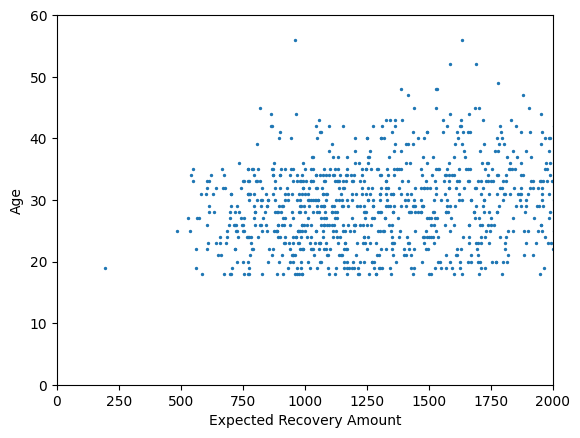

In [2]:
# Scatter plot of Age vs. Expected Recovery Amount
from matplotlib import pyplot as plt
x=df['expected_recovery_amount']
y=df['age']
s=2
plt.scatter(x , y , s )
plt.xlim(0, 2000)
plt.ylim(0, 60)
plt.xlabel('Expected Recovery Amount')
plt.ylabel('Age')
# ... YOUR CODE FOR TASK 2 ...
plt.show()

# **3. Statistical test: age vs. expected recovery amount**

We want to convince ourselves that variables such as age and sex are similar above and below the $1000 Expected Recovery Amount threshold. This is important because we want to be able to conclude that differences in the actual recovery amount are due to the higher Recovery Strategy and not due to some other difference like age or sex.

The scatter plot of age versus Expected Recovery Amount did not show an obvious jump around $1000. We will now do statistical analysis examining the average age of the customers just above and just below the threshold. We can start by exploring the range from $900 to $1100.

For determining if there is a difference in the ages just above and just below the threshold, we will use the Kruskal-Wallis test, a statistical test that makes no distributional assumptions.



In [3]:
from scipy import stats

x = df['expected_recovery_amount']<1100

y = df['expected_recovery_amount']>=900
# Compute average age just below and above the threshold
era_900_1100 = df.loc[(x) &
                      (y)]
by_recovery_strategy = era_900_1100.groupby(['recovery_strategy'])
by_recovery_strategy['age'].describe().stack()


Level_0_age = era_900_1100.loc[df['recovery_strategy']=="Level 0 Recovery"]['age']
Level_1_age = era_900_1100.loc[df['recovery_strategy']=="Level 1 Recovery"]['age']

# Perform Kruskal-Wallis test
statistic, p_value = stats.kruskal(Level_0_age, Level_1_age)

# Print the results
print(f"Kruskal-Wallis \nstatistic: {statistic:.4f}")
print(f"p-value: {p_value:.4f}")

Kruskal-Wallis 
statistic: 3.4572
p-value: 0.0630


# **4. Statistical test: sex vs. expected recovery amount**

We have seen that there is no major jump in the average customer age just above and just below the $1000 threshold by doing a statistical test as well as exploring it graphically with a scatter plot.

We want to also test that the percentage of customers that are male does not jump across the $1000 threshold. We can start by exploring the range of $900 to $1100 and later adjust this range.

We can examine this question statistically by developing cross-tabs as well as doing chi-square tests of the percentage of customers that are male vs. female.

In [4]:
crosstab = pd.crosstab(df.loc[(df['expected_recovery_amount']<1100) &
                              (df['expected_recovery_amount']>=900)]['recovery_strategy'],
                       df['sex'])
# ... YOUR CODE FOR TASK 4 ...
print(crosstab)
# Chi-square test
chi2_stat, p_val, dof, ex = stats.chi2_contingency(crosstab)
# ... YOUR CODE FOR TASK 4 ...
p_val

sex                Female  Male
recovery_strategy              
Level 0 Recovery       32    57
Level 1 Recovery       39    55


0.5377947810444592

# **5. Exploratory graphical analysis: recovery amount**

We are now reasonably confident that customers just above and just below the $1000 threshold are, on average, similar in their average age and the percentage that are male.

It is now time to focus on the key outcome of interest, the actual recovery amount.

A first step in examining the relationship between the actual recovery amount and the expected recovery amount is to develop a scatter plot where we want to focus our attention at the range just below and just above the threshold. Specifically, we will develop a scatter plot of Expected Recovery Amount (Y) vs. Actual Recovery Amount (X) for Expected Recovery Amounts between $900 to $1100. This range covers Levels 0 and 1. A key question is whether or not we see a discontinuity (jump) around the $1000 threshold.

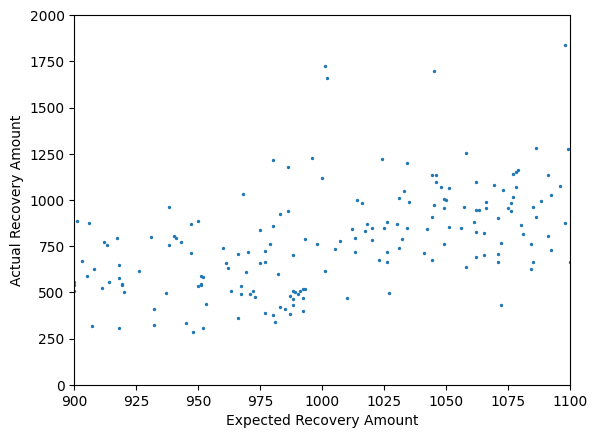

In [5]:
from matplotlib import pyplot as plt
x=df['expected_recovery_amount']
y=df['actual_recovery_amount']
s=2
plt.scatter(x , y , s )
plt.xlim(900, 1100)
plt.ylim(0, 2000)
plt.xlabel('Expected Recovery Amount')
plt.ylabel('Actual Recovery Amount')
# ... YOUR CODE FOR TASK 2 ...
plt.show()

# **6. Statistical analysis: recovery amount**

As we did with age, we can perform statistical tests to see if the actual recovery amount has a discontinuity above the $1000 threshold. We are going to do this for two different windows of the expected recovery amount $900 to $1100 and for a narrow range of $950 to $1050 to see if our results are consistent.

Again, we will use the Kruskal-Wallis test.

We will first compute the average actual recovery amount for those customers just below and just above the threshold using a range from $900 to $1100. Then we will perform a Kruskal-Wallis test to see if the actual recovery amounts are different just above and just below the threshold. Once we do that, we will repeat these steps for a smaller window of $950 to $1050

In [14]:
by_recovery_strategy['actual_recovery_amount'].describe().unstack()

Level_0_actual = era_900_1100.loc[df['recovery_strategy']=='Level 0 Recovery']['actual_recovery_amount']
Level_1_actual = era_900_1100.loc[df['recovery_strategy']=='Level 1 Recovery']['actual_recovery_amount']

print(f"Kruskal-Wallis \nstatistic: {statistic:.4f}")
print(f"p-value: {p_value:.4f} \n")

x = df['expected_recovery_amount']<1050

y = df['expected_recovery_amount']>=950

# Compute average age just below and above the threshold
era_950_1050 = df.loc[(x) &
                      (y)]


Level_0_actual = era_950_1050.loc[df['recovery_strategy']=='Level 0 Recovery']['actual_recovery_amount']
Level_1_actual = era_950_1050.loc[df['recovery_strategy']=='Level 1 Recovery']['actual_recovery_amount']

# Perform Kruskal-Wallis test
statistic, p_value = stats.kruskal(Level_0_actual, Level_1_actual)

print(f"Kruskal-Wallis \nstatistic: {statistic:.4f}")
print(f"p-value: {p_value:.4f}")

Kruskal-Wallis 
statistic: 30.2460
p-value: 0.0000 

Kruskal-Wallis 
statistic: 30.2460
p-value: 0.0000


# **7. Regression modeling: no threshold**

We now want to take a regression-based approach to estimate the program impact at the $1000 threshold using data that is just above and below the threshold.

We will build two models. The first model does not have a threshold while the second will include a threshold.

The first model predicts the actual recovery amount (dependent variable) as a function of the expected recovery amount (independent variable). We expect that there will be a strong positive relationship between these two variables.

We will examine the adjusted R-squared to see the percent of variance explained by the model. In this model, we are not representing the threshold but simply seeing how the variable used for assigning the customers (expected recovery amount) relates to the outcome variable (actual recovery amount).

In [16]:
import statsmodels.api as sm

# Define X and y
X = era_900_1100['expected_recovery_amount']
y = era_900_1100['actual_recovery_amount']

X_train_sm = X
X_train_sm = sm.add_constant(X_train_sm)

# Build linear regression model
lm_sm = sm.OLS(y,X_train_sm.astype(float)).fit()


# Print out the model summary statistics
# ... YOUR CODE FOR TASK 7 ...


print(lm_sm.summary())

                              OLS Regression Results                              
Dep. Variable:     actual_recovery_amount   R-squared:                       0.261
Model:                                OLS   Adj. R-squared:                  0.256
Method:                     Least Squares   F-statistic:                     63.78
Date:                    Thu, 20 Jul 2023   Prob (F-statistic):           1.56e-13
Time:                            15:42:03   Log-Likelihood:                -1278.9
No. Observations:                     183   AIC:                             2562.
Df Residuals:                         181   BIC:                             2568.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

# **8. Regression modeling: adding true threshold**

From the first model, we see that the expected recovery amount's regression coefficient is statistically significant.

The second model adds an indicator of the true threshold to the model (in this case at $1000).

We will create an indicator variable (either a 0 or a 1) that represents whether or not the expected recovery amount was greater than $1000. When we add the true threshold to the model, the regression coefficient for the true threshold represents the additional amount recovered due to the higher recovery strategy. That is to say, the regression coefficient for the true threshold measures the size of the discontinuity for customers just above and just below the threshold.

If the higher recovery strategy helped recovery more money, then the regression coefficient of the true threshold will be greater than zero. If the higher recovery strategy did not help recovery more money, then the regression coefficient will not be statistically significant.



In [17]:
df['indicator_1000'] = np.where(df['expected_recovery_amount']<1000, 0, 1)
era_900_1100 = df.loc[(df['expected_recovery_amount']<1100) &
                      (df['expected_recovery_amount']>=900)]

# Define X and y
X = era_900_1100[['expected_recovery_amount', 'indicator_1000']]
y = era_900_1100['actual_recovery_amount']


X_train_sm = X
X_train_sm = sm.add_constant(X_train_sm)


# Build linear regression model
lm_sm = sm.OLS(y,X_train_sm.astype(float)).fit()

# Print the model summary
# ... YOUR CODE FOR TASK 8 ...
print(lm_sm.summary())

                              OLS Regression Results                              
Dep. Variable:     actual_recovery_amount   R-squared:                       0.314
Model:                                OLS   Adj. R-squared:                  0.307
Method:                     Least Squares   F-statistic:                     41.22
Date:                    Thu, 20 Jul 2023   Prob (F-statistic):           1.83e-15
Time:                            15:43:18   Log-Likelihood:                -1272.0
No. Observations:                     183   AIC:                             2550.
Df Residuals:                         180   BIC:                             2560.
Df Model:                               2                                         
Covariance Type:                nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

# **9. Regression modeling: adjusting the window**

The regression coefficient for the true threshold was statistically significant with an estimated impact of around $278. This is much larger than the $50 per customer needed to run this higher recovery strategy.

Before showing this to our manager, we want to convince ourselves that this result wasn't due to choosing an expected recovery amount window of $900 to $1100. Let's repeat this analysis for the window from $950 to $1050 to see if we get similar results.

The answer? Whether we use a wide ($900 to $1100) or narrower window ($950 to $1050), the incremental recovery amount at the higher recovery strategy is much greater than the $50 per customer it costs for the higher recovery strategy. So we conclude that the higher recovery strategy is worth the extra cost of $50 per customer.

In [ ]:
era_950_1050 = df.loc[(df['...']<...) &
                      (df['...']>=...)]

# Define X and y
X = ...[['expected_recovery_amount','indicator_1000']]
y = ...['actual_recovery_amount']

X_train_sm = X
X_train_sm = sm.add_constant(X_train_sm)


# Build linear regression model
lm_sm = sm.OLS(y,X_train_sm.astype(float)).fit()

# Print the model summary
# ... YOUR CODE FOR TASK 8 ...
print(lm_sm.summary())